# **CIFAR-10 DATA LOADING, VISUALIZING AND PREPROCESSING**

In [14]:

from tensorflow.keras.datasets import cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [15]:
x_train.shape

(50000, 32, 32, 3)

In [16]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [17]:
y_test.shape

(10000,)

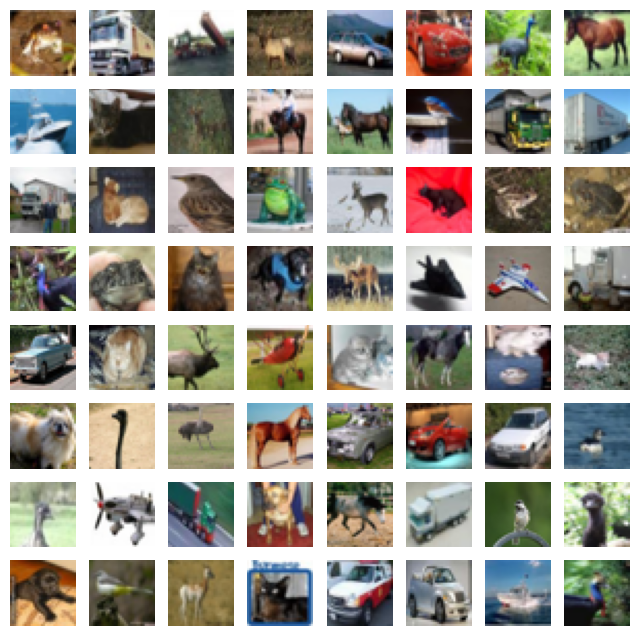

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(x_train[i], cmap = plt.cm.bone)
    ax.axis('Off')
plt.show()

In [19]:
pip install joblib

In [20]:
from skimage.feature import hog
from skimage.color import rgb2gray
from joblib import Parallel, delayed

def HogTransform(images):
    def hog_transform_single_image(im):
        gray_scale_image = rgb2gray(im)
        hog_transformed_image = hog(gray_scale_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        return hog_transformed_image
    hog_net = Parallel(n_jobs=-1)(delayed(hog_transform_single_image)(im) for im in images)

    return np.array(hog_net)

In [21]:
import numpy as np
x_train_hog = HogTransform(x_train)
x_test_hog = HogTransform(x_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [22]:
x_train_hog.shape

(50000, 324)

# **USING PCA, SCALING AND SVM**

In [23]:
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [24]:
pca = PCA()
pca.fit(x_train_hog)

PCA()

In [25]:
k = 0
csum=0
total = pca.explained_variance_.sum()
while csum/total <0.9:
    csum +=pca.explained_variance_[k]
    k=k+1
k

96

In [13]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(k)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train_hog, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=96)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [26]:


pipe.score(x_test_hog, y_test)

0.6274

In [27]:
y_pred = pipe.predict(x_test_hog)

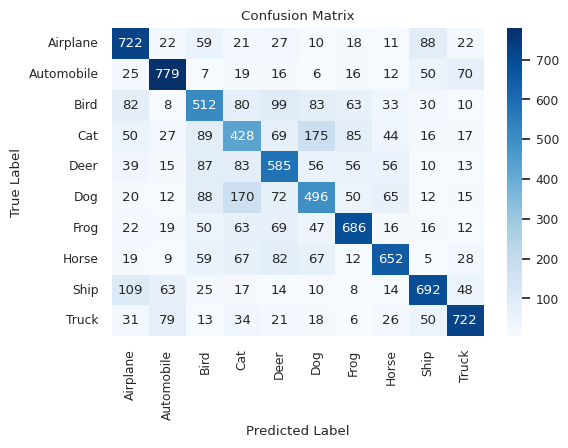

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.set(font_scale=0.8)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import classification_report as cr

print(cr(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1000
           1       0.75      0.78      0.77      1000
           2       0.52      0.51      0.51      1000
           3       0.44      0.43      0.43      1000
           4       0.56      0.58      0.57      1000
           5       0.51      0.50      0.50      1000
           6       0.69      0.69      0.69      1000
           7       0.70      0.65      0.68      1000
           8       0.71      0.69      0.70      1000
           9       0.75      0.72      0.74      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



# **USING CONVOLUTIONAL NEURAL NETWORKS (CUSTOM)**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = layers.Conv2D(128, 5, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(128, 5, padding='same', activation='relu')
        self.conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(256, 3, padding='same', activation='relu')
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.bn_conv1 = layers.BatchNormalization()
        self.bn_conv2 = layers.BatchNormalization()
        self.bn_conv3 = layers.BatchNormalization()
        self.bn_conv4 = layers.BatchNormalization()
        self.bn_dense1 = layers.BatchNormalization()
        self.bn_dense2 = layers.BatchNormalization()
        self.dropout_conv = layers.Dropout(0.25)
        self.dropout = layers.Dropout(0.5)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation='relu')
        self.fc2 = layers.Dense(512, activation='relu')
        self.fc3 = layers.Dense(10)

    def conv_layers(self, x):
        out = self.conv1(x)
        out = self.bn_conv1(out)
        out = self.conv2(out)
        out = self.bn_conv2(out)
        out = self.pool(out)
        out = self.dropout_conv(out)
        out = self.conv3(out)
        out = self.bn_conv3(out)
        out = self.conv4(out)
        out = self.bn_conv4(out)
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out

    def dense_layers(self, x):
        out = self.fc1(x)
        out = self.bn_dense1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn_dense2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

    def call(self, x):
        out = self.conv_layers(x)
        out = self.flatten(out)
        out = self.dense_layers(out)
        return out



In [ ]:

net = Net()

if tf.config.experimental.list_physical_devices('GPU'):
    device = '/GPU:0'
    net.build((None, 32, 32, 3))
else:
    device = '/CPU:0'
print('Device:', device)

num_params = sum(tf.size(w) for w in net.trainable_weights)
print("Number of trainable parameters:", num_params)

Device: /GPU:0
Number of trainable parameters: tf.Tensor(18617482, shape=(), dtype=int32)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:

net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])


history = net.fit(x_train, y_train,
                  validation_split=0.2,
                  batch_size=128,
                  epochs=12,
                  verbose=1,
                  callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0)],
                  )

Epoch 1/12
313/313 [==============================] - 71s 91ms/step - loss: 0.2466 - accuracy: 0.9159 - val_loss: 1.0485 - val_accuracy: 0.7042 - lr: 0.0100
Epoch 2/12
313/313 [==============================] - 28s 91ms/step - loss: 0.3316 - accuracy: 0.8878 - val_loss: 0.6851 - val_accuracy: 0.8078 - lr: 0.0100
Epoch 3/12
313/313 [==============================] - 29s 93ms/step - loss: 0.1782 - accuracy: 0.9389 - val_loss: 0.7730 - val_accuracy: 0.8055 - lr: 0.0100
Epoch 4/12
313/313 [==============================] - 29s 93ms/step - loss: 0.1442 - accuracy: 0.9518 - val_loss: 0.7642 - val_accuracy: 0.8166 - lr: 0.0100
Epoch 5/12
313/313 [==============================] - 29s 93ms/step - loss: 0.1389 - accuracy: 0.9533 - val_loss: 0.7952 - val_accuracy: 0.8088 - lr: 0.0100
Epoch 6/12
313/313 [==============================] - 28s 90ms/step - loss: 0.1480 - accuracy: 0.9514 - val_loss: 1.4690 - val_accuracy: 0.5748 - lr: 0.0100
Epoch 7/12
313/313 [==============================] - 28s 

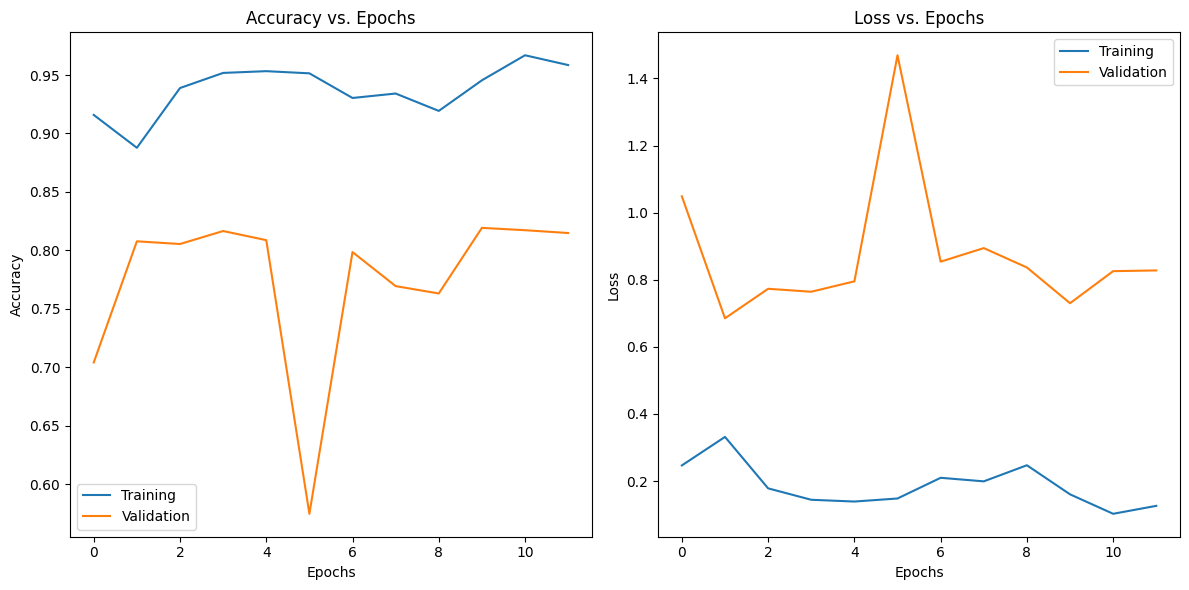

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


history_df = pd.DataFrame(history.history)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
history_df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])


plt.subplot(1, 2, 2)
history_df[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()


In [ ]:
y_pred = np.argmax(net.predict(x_test),axis=1)

313/313 [==============================] - 2s 7ms/step


In [ ]:
y_pred

array([5, 8, 1, ..., 5, 1, 7])

In [ ]:
from sklearn.metrics import classification_report as cr

In [ ]:
print(cr(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1000
           1       0.91      0.91      0.91      1000
           2       0.71      0.73      0.72      1000
           3       0.73      0.58      0.64      1000
           4       0.75      0.83      0.79      1000
           5       0.71      0.80      0.75      1000
           6       0.77      0.91      0.84      1000
           7       0.89      0.85      0.87      1000
           8       0.94      0.85      0.89      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



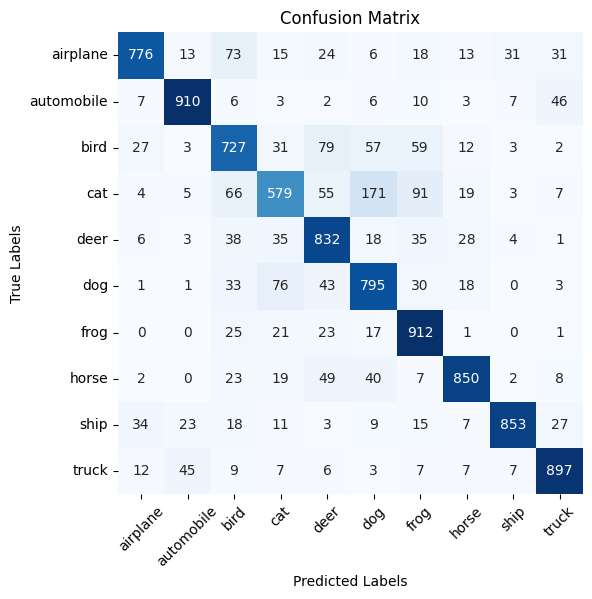

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


conf_matrix = confusion_matrix(y_test,y_pred)


plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


Predicted class: 0
Predicted label: airplane
